In [1]:
# %pip install plotly
# %pip install nltk
# # %pip install tensorflow
# # %pip install seaborn
# # %pip install sklearn
# # %pip install pandas
# %pip install cufflinks
# # %pip install jupyterlab 
# %pip install ipywidgets
# %pip install pydot

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time
from datetime import date
# Not supported in python 3.7 or above
# from wordcloud import WordCloud, STOPWORDS
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import re
# Natural Language Tool Kit
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
import cufflinks as cf
import pandas as pd
cf.go_offline()

C:\Users\manis\AppData\Local\Temp\ipykernel_6532\1384890414.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
data_df = pd.read_csv("data.csv")
print(f"Data shape {data_df.shape}")
data = data_df.iloc[:500000,:]
print(f"Data shape {data.shape}")

Data shape (1371202, 4)
Data shape (500000, 4)


In [32]:
data.isna().sum()

id               0
location    152289
text             0
target           0
dtype: int64

In [33]:
data = data.dropna()
data.groupby('target').describe()

id                                                         \
           count           mean            std  min       25%       50%   
target                                                                    
0       141024.0  237680.267919  142352.641442  1.0  115225.5  232338.5   
1       206687.0  259837.118508  145114.365454  3.0  143480.0  262360.0   

                            
             75%       max  
target                      
0       354997.5  499997.0  
1       388879.5  499996.0

In [34]:
df_spam = data[data['target']==0]
df_spam.shape

(141024, 4)

In [35]:
df_ham = data[data['target']==1]
df_ham.shape

(206687, 4)

In [36]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(141024, 4)

In [37]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(282048, 4)

In [38]:
df_balanced['target'].value_counts()
df_balanced

,id,location,text,target
441381,441382,dallas,The disease shocked the world: America’s RESPO...,1
314076,314077,"Oakland, CA",RT @NPRHealth: Top Pediatrician Says States Sh...,1
493156,493157,Worcester MA,RT @PhilipRucker: “The good ship Trump has spr...,1
399444,399445,NYC,#WTF?!! Exclusive: CDC Won't Release School Gu...,1
187125,187126,"Dayton,virginia",RT @cherokeesher2: https://t.co/PzjtvVzO0s,1
...,...,...,...,...
499986,499987,"London, U.K.",RT @guardian: Coronavirus live news: global ca...,0
499991,499992,"England, United Kingdom",RT @guardiannews: Texas hospital forced to set...,0
499992,499993,Belfast,RT @Ajmistry1: Britain wins rare praise for le...,0
499994,499995,south africa western cape,https://t.co/wvAlF0SyXn,0


In [39]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_url(text):
    no_html= pattern.sub('',text)
    return no_html

# Remove all text that start with http
df_balanced.text = df_balanced.text.apply(lambda x: remove_url(x))
df_balanced.head()

,id,location,text,target
441381,441382,dallas,The disease shocked the world: America’s RESPO...,1
314076,314077,"Oakland, CA",RT @NPRHealth: Top Pediatrician Says States Sh...,1
493156,493157,Worcester MA,RT @PhilipRucker: “The good ship Trump has spr...,1
399444,399445,NYC,#WTF?!! Exclusive: CDC Won't Release School Gu...,1
187125,187126,"Dayton,virginia",RT @cherokeesher2:,1


In [40]:
# now remove stopwords, change to lowercase

def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    # split to array (default delimiter is " ")
    text = text.split()
    text = [w for w in text if not w in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

print("Cleaning text...")
df_balanced.text = df_balanced.text.apply(lambda x : clean_text(x))


Cleaning text...


KeyboardInterrupt: 

In [24]:
# How many unique words int this dataset

def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

text_values = df_balanced.text
counter = counter_word(text_values)
print(f"The len of words is: {len(counter)}")
list(counter.items())[:10]

The len of words is: 207877


[('greenejarrett', 1),
 ('realjustinreed', 1),
 ('droakley', 5),
 ('rt', 334805),
 ('jrubinblogger', 1030),
 ('must', 5304),
 ('battle', 1514),
 ('covid', 195312),
 ('ignorant', 401),
 ('destructive', 218)]

In [25]:
train, test, train_category, test_category = train_test_split(df_balanced.text, df_balanced.target, test_size=0.30, random_state=42)
train_category.value_counts()
train.head(4)

132946    bored chinese man lockdown runs miles living room
234885      soaring drug overdose deaths us covid increases
694173    rt aslavitt really feel like u given european ...
437532    coronavirus fishermen test positive despite sp...
Name: text, dtype: object

In [26]:
test_category.value_counts()

0    114314
1    114058
Name: target, dtype: int64

In [36]:
# The maximum number of words to be used. (most frequent)

# vocab_size = len(counter)
# embedding_dim = 32

# # Max number of words in each complaint
# max_length = 20
# trunc_type = 'post'
# padding_type = 'pre'

# # oov_took its set for words out our word index
# oov_tok = "<XXX>"
# training_size = int(len(train) * 0.8)
# seq_len = 12

# # based on 80% of the data
# training_sentences = train[0:training_size]
# training_labels = train_category[0:training_size]

# valid_sentences = train[training_size:]
# valid_labels = train_category[training_size:]

# print('The Shape of training ',training_sentences.shape)
# print('The Shape of testing',valid_sentences.shape)

In [37]:
# training_labels.value_counts()

In [38]:
# valid_labels.value_counts()

In [39]:
# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# tokenizer.fit_on_texts(training_sentences)
# word_index = tokenizer.word_index

In [40]:
# # Lets see the first 10 elements
# print("THe first word Index are: ")
# for x in list(word_index)[0:15]:
#     print (" {},  {} ".format(x,  word_index[x]))

In [41]:
# training_sequences = tokenizer.texts_to_sequences(training_sentences)
# training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# T = training_padded.shape[0]
# print("The shape of training data is: ",training_padded.shape, T)

In [42]:
# valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
# valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# print("The shape of validation data is: ",valid_padded.shape)

In [27]:
import tensorflow_hub as hub
import tensorflow_text as text
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [28]:
#Model Definition with LSTM

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.LSTM(64, return_sequences=True),
#     tf.keras.layers.LSTM(64),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid') # binary classification
# ])


#using BERT
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])







# #working model
# i = tf.keras.layers.Input(shape=(max_length,))
# x= tf.keras.layers.Embedding(vocab_size+1, embedding_dim)(i)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
# # x = tf.keras.layers.Dropout(0.2)(x)    #optional might be better to use dropout
# x = tf.keras.layers.GlobalMaxPooling1D()(x)
# x = tf.keras.layers.Dense(1, activation='sigmoid')(x)



# i = tf.keras.layers.Input(shape=(max_length,))
# x = tf.keras.layers.Embedding(vocab_size+1, embedding_dim)(i)
# x = tf.keras.layers.Conv1D(32, 3, activation='relu')(x)
# x = tf.keras.layers.MaxPooling1D(3)(x)
# x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
# # x = tf.keras.layers.MaxPooling1D(3)(x)
# x = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)
# x = tf.keras.layers.GlobalMaxPooling1D()(x)
# x = tf.keras.layers.Dense(1, activation='sigmoid')(x)


# model = tf.keras.models.Model(inputs=i, outputs=x)

model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss= 'binary_crossentropy' , metrics=['accuracy'])
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

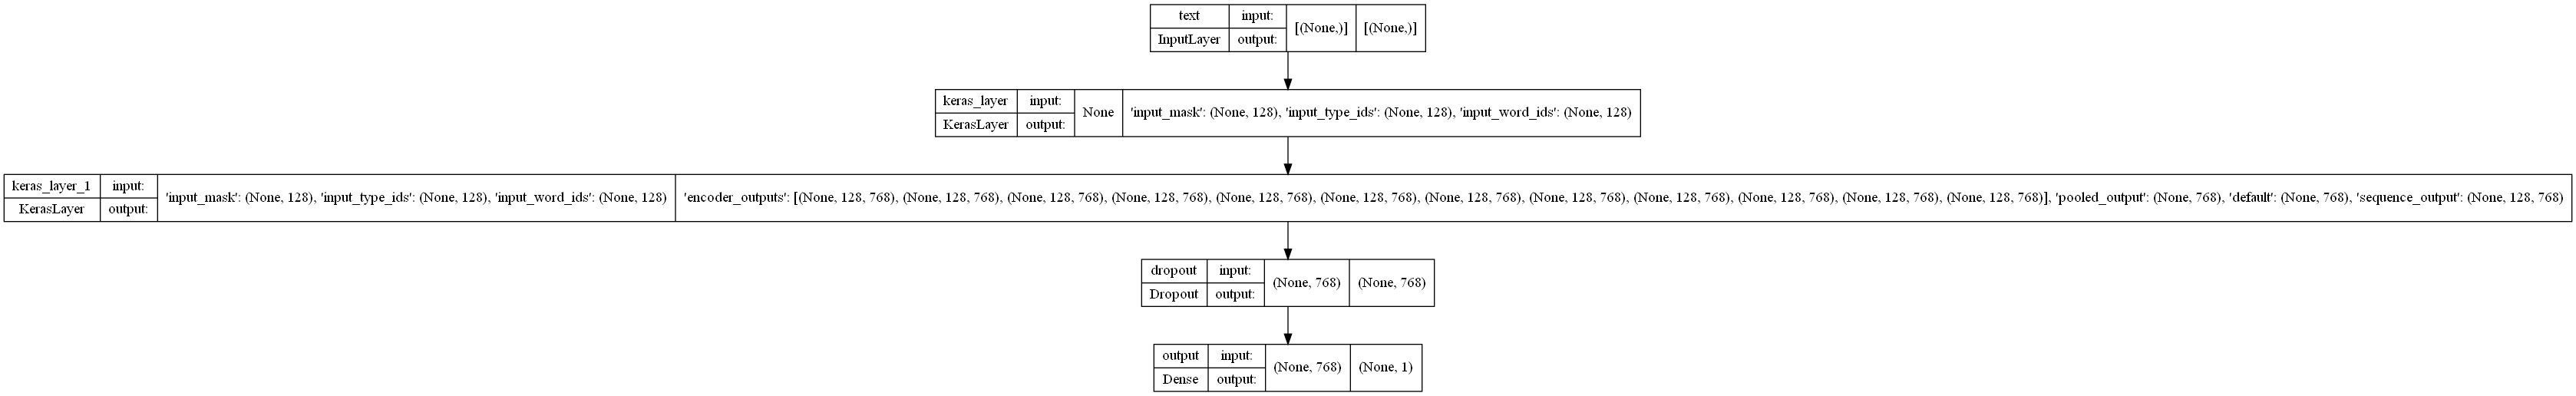

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [30]:
num_epochs = 10
history = model.fit(train, train_category, epochs=num_epochs, validation_data=(test, test_category))


Epoch 1/10
  686/16653 [>.............................] - ETA: 1:05:22 - loss: 0.6617 - accuracy: 0.6019

KeyboardInterrupt: 

In [52]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

TypeError: no numeric data to plot

In [47]:
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1])

KeyError: "None of [Index(['accuracy', 'val_accuracy'], dtype='object')] are in the [columns]"

In [48]:
predictions = (model.predict(valid_padded) > 0.5).astype("int32")
predictions

ValueError: in user code:

    File "C:\Users\manis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\manis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\manis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\manis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\manis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "keras_layer" (type KerasLayer).
    
    in user code:
    
        File "C:\Users\manis\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_hub\keras_layer.py", line 237, in call  *
            result = smart_cond.smart_cond(training,
    
        ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
          Positional arguments (3 total):
            * Tensor("inputs:0", shape=(None, 20), dtype=string)
            * False
            * None
          Keyword arguments: {}
        
         Expected these arguments to match one of the following 4 option(s):
        
        Option 1:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='sentences')
            * False
            * None
          Keyword arguments: {}
        
        Option 2:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='sentences')
            * True
            * None
          Keyword arguments: {}
        
        Option 3:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
            * False
            * None
          Keyword arguments: {}
        
        Option 4:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
            * True
            * None
          Keyword arguments: {}
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 20), dtype=string)
      • training=False


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
# Showing Confusion Matrix
plot_cm(valid_labels,predictions, 'Confusion matrix of Validation Dataset', figsize=(7,7))

NameError: name 'predictions' is not defined

In [50]:
testing_sequences = tokenizer.texts_to_sequences(test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = (model.predict(testing_padded) > 0.5).astype("int32")

predictions

ValueError: in user code:

    File "C:\Users\manis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\manis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\manis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\manis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\manis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "keras_layer" (type KerasLayer).
    
    in user code:
    
        File "C:\Users\manis\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_hub\keras_layer.py", line 237, in call  *
            result = smart_cond.smart_cond(training,
    
        ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
          Positional arguments (3 total):
            * Tensor("inputs:0", shape=(None, 20), dtype=string)
            * False
            * None
          Keyword arguments: {}
        
         Expected these arguments to match one of the following 4 option(s):
        
        Option 1:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='sentences')
            * False
            * None
          Keyword arguments: {}
        
        Option 2:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='sentences')
            * True
            * None
          Keyword arguments: {}
        
        Option 3:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
            * False
            * None
          Keyword arguments: {}
        
        Option 4:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
            * True
            * None
          Keyword arguments: {}
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 20), dtype=string)
      • training=False


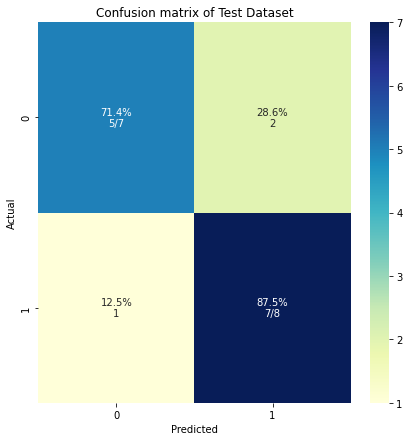

In [37]:
# Showing Confusion Matrix
plot_cm(test_category,predictions, 'Confusion matrix of Test Dataset', figsize=(7,7))

In [35]:
model.save(f"models/Bi-LSTM ({date.today().strftime('%m-%d-%y')})")

2022-01-07 18:47:55.292745: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Bi-LSTM (01-07-2022)/assets


INFO:tensorflow:Assets written to: Bi-LSTM (01-07-2022)/assets
